In [1]:
### This script attempts to conduct supervised machine learning on 10 years’ 
# worth of LANDSAT data with the aim of creating an animation that shows land use change over time. 

# The following module provides an automated way of downloading LANDSAT imagery from earth explorer
# – almost certainly worth exploring for future projects
# https://github.com/yannforget/landsatxplore

# For this script you'll need a shape file containing polygons that have been classified 
# according to their land use. These polygons can either be ground truth (i.e., information 
# taken from governmental websites or other research institutions) or you can manually 
# classify land use in the study area using Google Earth. 

import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import os
import fnmatch
import sys
from TOA_reflectance_stacker import histogram_stretch
from tqdm import tqdm
import earthpy.plot as ep
import shapely
from matplotlib.colors import ListedColormap

In [2]:
# Get the current directory
current_directory = os.getcwd()

# List all files in the directory
all_files = os.listdir(current_directory)

# Filter files that contain "STACKED_CROPPED" in their filename
filtered_files = [filename for filename in all_files if "STACKED_CROPPED" in filename]

# these files are automatically sorted by date acquired (filenaming conventions) from oldest
# to youngest
filtered_files

['LC08_L1TP_113037_20140423_20200911_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20151019_20200908_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20160514_20200907_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20180317_20200901_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20180808_20200831_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20190507_20200829_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20200306_20200822_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20211120_20211130_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20230502_20230509_02_T1_TOA_STACKED_CROPPED.tif']

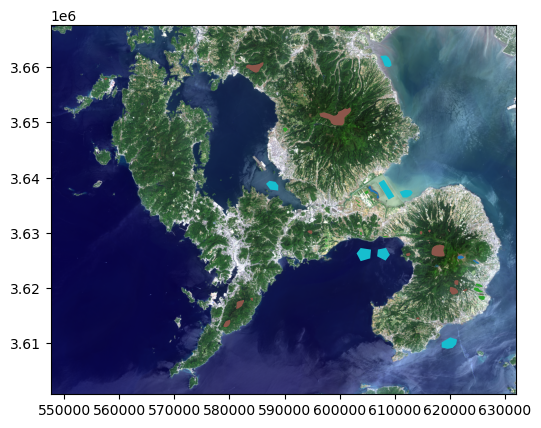

In [3]:
# Plot the true color composite of the study area as well as the classified polygons that 
# will be used as the training data

src = rio.open(filtered_files[-1])
tcc = src.read([4,3,2])

training_polygons = gpd.read_file("Supervised Land Use Updated.geojson")

fig, ax = plt.subplots()

# Note that we have to use rasterio show here rather than ax.imshow because the training 
# polygons are plotted using coordinates. Furthermore note that the histogram stretch function 
# returns a numpy array; thus you need to provide a transform argument in order to convert that 
# numpy array into coordinates
show(histogram_stretch(tcc, 0, 99), ax = ax, transform = src.transform)
training_polygons.plot(column = "LULC", ax = ax)
src.close()

In [4]:
# it is very important to make sure that the CRS of your raster and shapefiles are the same
# There are a lot of geopandas and rasterio functions that will straight up not work if the 
# two files are not in the same CRS
training_polygons.crs == src.crs

True

In [5]:
# We now need to get the band data from the raster image based on the training polygons

# To prep the data for ML analysis, we need two numpy arrays:
# X: a numpy array that contains all of the band data for the pixel
# y: the labels for training
X = np.array([], dtype = np.float32).reshape(0,10) # Create an array with 10 columns and 0 rows
                                                  # we're gonna stack new pixels inside
y = np.array([], dtype = np.string_) # labels for training

# train May 2023 data
with rio.open(filtered_files[-1]) as src:
    band_count = src.count
    band_id = src.descriptions
    
    # Iterate
    for index, row in training_polygons.iterrows():
        feature = [row["geometry"]]
        
        # crop the image - mask function returns a tuple
        out_image, out_transform = rio.mask.mask(src, feature, crop = True)
        
        # out_image has a shape (7, height, width)
        
        # Since this returns a rectangular array, and our shape is not rectangular, there will be
        # a bunch of nans - get rid of them.
        
        # note that this gets rid of any column that has ANY nans
        # The following code returns a row for each band, with each column representing a pixel
        out_image_trimmed = out_image[:, ~np.any(np.isnan(out_image), axis = 0)]
        
        # We actually want this the other way around - we want a row for pixel, and a column for each
        # band - so we transpose the image
        out_image_trimmed = out_image_trimmed.T
        
        # We append the labels to the answer array equal to the number of pixels:
        # Remember to put brackets around the row["LULC"], or else you'll get "forestforestforest"
        y = np.append(y, [row["LULC"]] * out_image_trimmed.shape[0])
        
        # vstack is like concat for rows. Note that to vstack correctly, the array tuple that you feed
        # to vstack must have the same column dimension
        X = np.vstack((X, out_image_trimmed))

src.close()

In [6]:
### Check if it worked correctly: Two arrays should have the same number of rows/columns
print(X.shape)
print(y.shape)

# We need to scale the data: remember, thermal emissivity data is not on the same scale as 
# TOA reflectance data

# In some cases we may need to scale the data - this depends on the supervised machine learning
# model that we intend to use: some machine learning models do not require scaling such as naive 
# bayes as well as random forest, while others do require scaling, such as linear regression

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

(58663, 10)
(58663,)


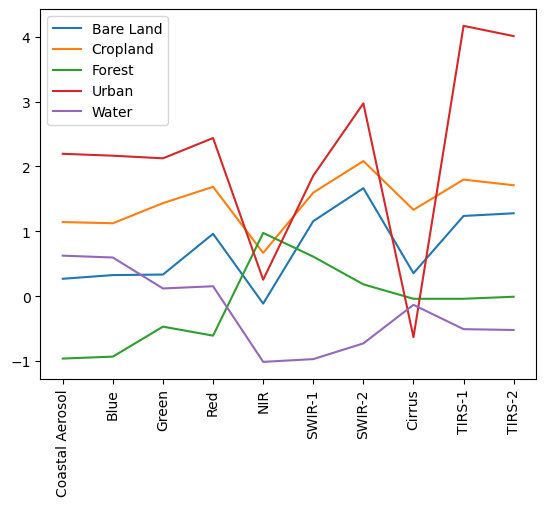

In [7]:
# We can now check what each of the four different classifications looks like based on their band data

fig, ax = plt.subplots()

for landuse in np.unique(y):
    ax.plot(np.arange(1,11), np.mean(X[y == landuse, :], axis = 0), label = landuse)

# We can see that cropland and urban areas have very similar distributions across the 
# different bands - this suggests that there may be cases where cropland and urban areas are
# misclassified as each other
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(src.descriptions, rotation = 90)
ax.legend()

[0.44235623 0.7889859  0.9293961  0.97979605 0.9921303  0.9980958
 0.9992605  0.99966955 0.99991924 0.9999999 ]


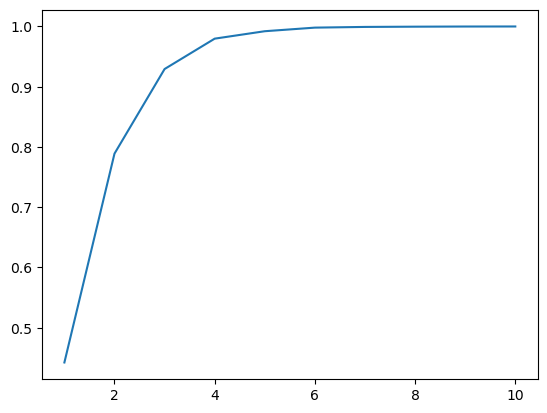

In [15]:
# We can try PCA to reduce the number of features in order to increase the speed at which we process 
# the data
%matplotlib inline

from sklearn.decomposition import PCA

pca = PCA()

# fit the PCA model on X
pca.fit(X)

# The graph shows the percentage of variance explained by each principal component - we can see
# that we only really need about 5 features to explain 99% of the data
print(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))

In [16]:
# We can now train our supervised learning model – we'll start with an extremely simple 
# gaussian naive bayes model
from sklearn.naive_bayes import GaussianNB

# This one has no hyperparameters
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

In [19]:
# All of the above steps can actually be combined into a single Pipeline object available in sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline
from sklearn.pipeline import make_pipeline

# Pipelines are extremely useful for sending your data through a preprocessing pipeline and out into 
# a model. You instantiate A pipeline object using the make_pipeline function, you then pass it 
# several objects that have a fit_transform function, such as standard scaler or PCA. The final 
# object in the pipeline should be a model, in other words an object that has a fit_predict method.
# Then, when you run pipeline.fit_predict(X, y), the pipeline will feed X through all of the objects 
# that you specified in the pipeline. Note that you cannot have multiple estimators in a pipeline 

pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components = 5), GaussianNB(priors=None))
pipeline = make_pipeline(StandardScaler(), GaussianNB(priors=None))

# To prep the data for ML analysis, we need two numpy arrays:
# X: a numpy array that contains all of the band data for the pixel
# y: the labels for training
X = np.array([], dtype = np.float32).reshape(0,10) # Create an array with 10 columns and 0 rows
                                                  # we're gonna stack new pixels inside
y = np.array([], dtype = np.string_) # labels for training

# train May 2023 data
with rio.open(filtered_files[-1]) as src:
    band_count = src.count
    band_id = src.descriptions
    
    # Iterate
    for index, row in training_polygons.iterrows():
        feature = [row["geometry"]]
        
        # crop the image - mask function returns a tuple
        out_image, out_transform = rio.mask.mask(src, feature, crop = True)
        
        # out_image has a shape (7, height, width)
        
        # Since this returns a rectangular array, and our shape is not rectangular, there will be
        # a bunch of nans - get rid of them.
        
        # note that this gets rid of any column that has ANY nans
        # The following code returns a row for each band, with each column representing a pixel
        out_image_trimmed = out_image[:, ~np.any(np.isnan(out_image), axis = 0)]
        
        # We actually want this the other way around - we want a row for pixel, and a column for each
        # band - so we transpose the image
        out_image_trimmed = out_image_trimmed.T
        
        # We append the labels to the answer array equal to the number of pixels:
        # Remember to put brackets around the row["LULC"], or else you'll get "forestforestforest"
        y = np.append(y, [row["LULC"]] * out_image_trimmed.shape[0])
        
        # vstack is like concat for rows. Note that to vstack correctly, the array tuple that you feed
        # to vstack must have the same column dimension
        X = np.vstack((X, out_image_trimmed))

src.close()

# We can then fit our X_train and y_train data using th above pipeline
pca_pipeline.fit(X, y)
pipeline.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [21]:
# We can save the trained models using python's persistence models, namely pickle. However, 
# sklearn recommends the use of joblib because it is more efficient at saving objects that carry 
# large internal numpy arrays as is usually the case for supervised models
from joblib import dump, load

dump(pipeline, 'pipeline.joblib') 
dump(pca_pipeline, 'pca_pipeline.joblib') 

# Models can be loaded later using the following syntax
# clf = load('filename.joblib')

['pca_pipeline.joblib']

In [133]:
# Train on May 2023
src = rio.open(filtered_files[-1])

dataset = src.read()
src.close()

# reshape the data from the entire dataset:
height = dataset.shape[1]
width = dataset.shape[2]

new_shape = (height * width, dataset.shape[0])
# swap axes and reshape
X_test = dataset.swapaxes(0,2).reshape(new_shape)

# scale and fir the data - note that we do not use "fit" since our models are already trained
# X_test = scaler.transform(X_test)
# y_test = gnb.predict(X_test)
y_test = pipeline.predict(X_test)

# Reshape back into a 2D array
y_test = y_test.reshape(width, height).T

In [134]:
# Use this to transform our nagasaki_reshaped (which has a bunch fo string labels) into integers

lulc_dict = dict((
    ("Urban", 0),
    ("Cropland", 1),
    ("Forest", 2),
    ("Water", 3),
    ("Bare Land", 4),
))

# Invert dictionary
inv_dict = {v: k for k, v in lulc_dict.items()}

# apparently faster - returns unique values as well as the indices that can be used to reconstruct
# the array
u, inv = np.unique(y_test, return_inverse = True)
y_labels = np.array([lulc_dict[x] for x in u])[inv].reshape(y_test.shape)

In [135]:
# Set up dictionary for color map
colors = dict((
    (0, "grey"),   # Urban 
    (1, "xkcd:lime green"),      # Cropland 
    (2, "green"),    # Forest 
    (3, "blue"),   # Water 
    (4, "xkcd:brown")
))

cmap = ListedColormap([colors[key] for key in colors], name = "LULC")

In [136]:
%matplotlib qt5

# We can use the results of our supervised machine learning model to refine our training polygons

# So far the classification looks good – however, it is important to note that different LANDSAT 
# images were taken under different atmospheric conditions; consequently, there may be issues in 
# other scenes especially since we know that bare land and cropland have very similar spectral 
# signatures
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y_labels, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(dataset[[3,2,1],:,:], 0, 99)))
ep.draw_legend(im_ax = i, titles = [inv_dict[key] for key in np.unique(y_labels)], cmap = cmap)
plt.tight_layout()

In [137]:
# We can now attempt to conduct this workflow on the time-series data.
from datetime import datetime

# first, let's create a list of dates from the filenames
# This code is a bit long winded but all it's doing is reformatting the dates from the filenames
# into more human-readable dates
dates = [datetime.strptime(filename.split("_")[3], '%Y%m%d').strftime('%d %B %Y') for filename in filtered_files]

dates

['23 April 2014',
 '19 October 2015',
 '14 May 2016',
 '17 March 2018',
 '08 August 2018',
 '07 May 2019',
 '06 March 2020',
 '20 November 2021',
 '02 May 2023']

In [139]:
# Let's do the same thing we did with our unsupervised machine learning script and create an 
# animation that shows the evolution of land use over time

# Create a dictionary to store the data
data_dict = {}

# For each cropped file, get the classified data
for i, filename in tqdm(enumerate(filtered_files)):
    src = rio.open(filename)
    data = src.read()
    src.close()
    
    # To be honest this should be the same for all rasters, but include just in case you're
    # using rasters of different dimensions for some reason
    height = data.shape[1]
    width = data.shape[2]
    new_shape = (height * width, data.shape[0])

    # swap axes and reshape
    X_test = data.swapaxes(0,2).reshape(new_shape)
    
    # Scale, conduct PCA, and predict
    y_test = pipeline.predict(X_test)
    
    y_test = y_test.reshape(width, height).T
    
    # Convert strings into integers
    u, inv = np.unique(y_test, return_inverse = True)
    y_labels = np.array([lulc_dict[x] for x in u])[inv].reshape(y_test.shape)
    
    # Store only the histogram stretched raster data – the only thing we use this data for is to
    # visualize the true color composite of the scene, so we get rid of all the other bands to be
    # memory efficient - Yup, pca saves about 2 seconds per iteration, but the results are significantly
    # worse
    data_dict[dates[i]] = (histogram_stretch(data[[3,2,1],:,:],0,99), y_labels)

9it [01:37, 10.84s/it]


In [140]:
# note that supervised machine learning takes a lot longer than unsupervised machine learning 
# – one way of speeding this up is to conduct PCA on the bands in order to reduce the number of 
# features

# Create a figure and axis for the animation
# Please see Geospatial Workflow – Animations for a more in depth explanation of how the 
# FuncAnimation class works
%matplotlib qt5
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 2, figsize = (20,10))

# Initialize an image plot containing the first frame
tcc_plot = ax[0].imshow(rio.plot.reshape_as_image(data_dict[dates[0]][0]))
lulc_plot = ax[1].imshow(data_dict[dates[0]][1], cmap = cmap, interpolation = "nearest")

# turn off axes for visual clarity
ax[0].axis("off")
ax[1].axis("off")

def update(frame):
    date = dates[frame]
    
    # load the image from the dictionary
    tcc_image = rio.plot.reshape_as_image(data_dict[date][0])
    lulc_image = data_dict[date][1]
    
    # set the image onto the figure
    tcc_plot.set_data(tcc_image)
    lulc_plot.set_data(lulc_image)
    
    ax[0].set_title(f"Nagasaki Prefecture Land Use, Gaussian Naive Bayes\n{date}", fontsize = 24, 
                    x = 1, y = 1)

# Call the funk animation class with the appropriate arguments. Frames indicates how many
# frames there will be IE how many frames will be passed into the `update` function, while
# repeat tells matplotlib whether to loop the animation, interval tells FuncAnimation how much time
# between frames
animation = FuncAnimation(fig, update, frames=len(dates), repeat=True, interval = 2000)
plt.tight_layout()

# Save the animation
animation_file = f'gnb_animation.gif'
animation.save(animation_file, writer='pillow')

plt.show()

In [141]:
# As we can see, supervised learning has issues similar to unsupervised learning, where the 
# different atmospheric conditions under which the images were taken have a significant effect 
# on the spectral signatures 

# Nevertheless it is still useful to generate zonal statistics from rest images in which 
# atmospheric conditions were relatively similar

# By visual inspection it looks like years 2014, 2016, and 2019 had atmospheric conditions were 
# that were relatively similar to the 2023 dataset. Let's isolate those years and run some zonal 
# statistics based on Nagasaki's municipal boundaries

In [147]:
# The first thing we need to do is write out all of the land use classification numpy arrays into
# their own rasters

# get profile information from one of the original rasters
init_src = rio.open(filtered_files[-1])
profile = init_src.profile
profile.update(dtype = np.uint8, nodata = 255, count = 1)
init_src.close()

for date in data_dict.keys():
    out_raster = rio.open(
        f"{datetime.strptime(date, '%d %B %Y').strftime('%Y%m%d')}_LULC_GNBClassified.tif",
        "w",
        **profile
    )
    
    out_raster.write(data_dict[date][1].astype(np.uint8), 1)
    out_raster.close()

In [155]:
import rasterstats
import pandas as pd

dates_of_interest = ["20140423", "20160514", "20190507", "20230502"]

# Read in a geodataframe of the boundaries of the municipalities in Nagasaki
mun_bounds = gpd.read_file("mun_bounds_cleaned.geojson")

for date in dates_of_interest:
    # If the targets are a shapefile and a tif, we can use rasterstats to call the actual files
    # note that 
    zonal_lulc_stats = rasterstats.zonal_stats(
        "mun_bounds_cleaned.geojson",
        f"{date}_LULC_GNBClassified.tif",
        categorical = True,   
        category_map = inv_dict
    )

    # Create list of dictionaries
    zonal_lulc_stats = pd.DataFrame(zonal_lulc_stats)
    # calculate proportion of forest in each municipality and add it to the mun_bounds df
    mun_bounds[f"{date[:4]}"] = zonal_lulc_stats.apply(lambda x: x.Forest / np.sum(x), axis = 1)

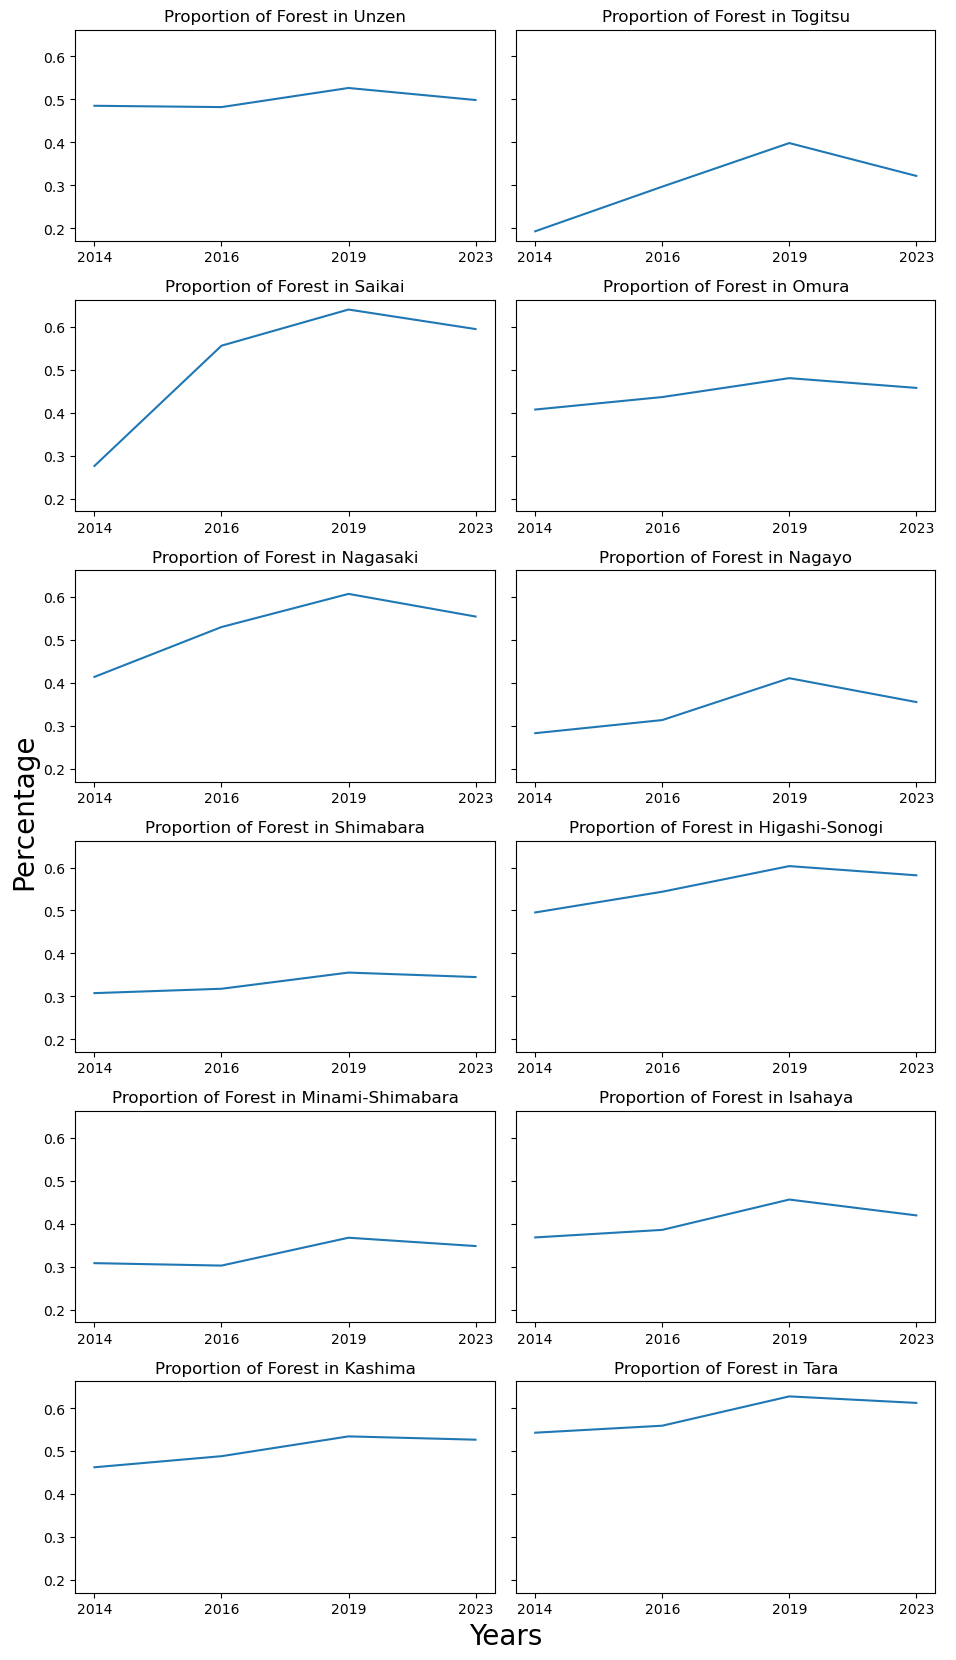

In [159]:
%matplotlib inline

# Calculate the number of rows and columns for the subplot grid
num_rows = 6
num_cols = 2

# Create a new figure and subplot grid
# sharex/sharey forces same axes for all plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 17), sharey = True)

# Flatten the subplot grid for easier iteration
axs = axs.flatten()

for index, row in mun_bounds.iterrows():
    # Create a bar chart for the current row
    # row.index gives the column names
    # row.values gives the value of those columns
    axs[index].plot(row.index[3:], row.values[3:])
                   ### COLOR TYPE 1: VARY COLOURS BASED ON VALUE
                   # Give the bar chart colours based on the value of the column
                   # e.g., >30% should be red, <10% should be green, etc.
                   # Can edit the custome colour scheme above
                   # color = cmap(norm(row.values[3:].astype(np.float64))))
                   
                   ### COLOR TYPE 2: VARY COLOURS BASED ON COLUMN
#                    color = cmap(norm(np.linspace(0,5,6))))
    # plt.bar(row.index[3:], row.values[3:])
    
    ## COLORS ##
    # Use this to help give barchart colors based on the value 
    # E.g., if you want 30% to be red or something
    # https://saturncloud.io/blog/color-matplotlib-bar-chart-based-on-value-a-guide/

    axs[index].set_title(f'Proportion of Forest in {row["name:en"]}')

    
# Workaround to add common X and Y label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
    
# Show the bar chart
plt.tight_layout()
plt.show()

In [169]:
# an alternative way of visualizing this is using an animation 
%matplotlib qt5
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize = (16,18))
ax.axis("off")
fontsize = 12

ims = []
t = []
vmin, vmax = 0.2, 0.6

def update_fig(frame):
    date = dates_of_interest[frame]
    
    if len(ims) > 0:
        del ims[0]

    geos = mun_bounds['geometry']
    forest_prop = mun_bounds[f"{date[:4]}"]
    
    # Note that this method will soon be deprecated
    artist = gpd.plotting.plot_polygon_collection(ax, geos, forest_prop, cmap="Greens")
    ims.append(artist)
    
    mun_bounds.apply(lambda x: ax.annotate(text = x["name:en"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)
    
    ax.set_title(f"Forested Area: {date[:4]}")
    fig = ax.get_figure()
    
    # Adds axes with the following arguments: left bottom width height
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    return ims

anim = FuncAnimation(fig, update_fig, interval=1000, repeat_delay=300, frames=len(dates_of_interest))
# plt.tight_layout()

animation_file = f'forest_prop_animation.gif'
anim.save(animation_file, writer='pillow')

fig.show()

C:\Users\tranq\AppData\Local\Temp\ipykernel_11124\412303574.py:23: FutureWarning: plot_polygon_collection is intended for internal use only, and will be deprecated.
  artist = gpd.plotting.plot_polygon_collection(ax, geos, forest_prop, cmap="Greens")


In [170]:
# From here we can calculate how the relative proportion of forested areas in each 
# municipality has changed over time
# mun_bounds = gpd.read_file("mun_bounds_cleaned.geojson")

# mun_bounds

,name:en,area,geometry,2014,2016,2019,2023
0,Unzen,208.396449,"MULTIPOLYGON (((606635.330 3617190.342, 606631...",0.485039,0.481990,0.526471,0.498458
1,Togitsu,20.879353,"MULTIPOLYGON (((575820.531 3637110.984, 575827...",0.192923,0.296754,0.398259,0.321753
2,Saikai,232.782378,"MULTIPOLYGON (((550528.743 3652271.062, 550517...",0.276060,0.555925,0.640114,0.594669
3,Omura,126.519727,"MULTIPOLYGON (((585408.055 3641409.508, 585396...",0.407291,0.436386,0.480398,0.457685
4,Nagasaki,405.712597,"MULTIPOLYGON (((551699.236 3636587.989, 551697...",0.414392,0.530369,0.607555,0.554867
5,Nagayo,28.744017,"MULTIPOLYGON (((580289.037 3635102.766, 580295...",0.283298,0.313833,0.411293,0.355767
6,Shimabara,82.896250,"MULTIPOLYGON (((628768.656 3625254.691, 628765...",0.307559,0.317743,0.355417,0.344961
7,Higashi-Sonogi,74.189358,"MULTIPOLYGON (((585736.548 3655197.079, 585740...",0.495372,0.543602,0.603270,0.581848
8,Minami-Shimabara,170.110766,"MULTIPOLYGON (((611641.602 3607560.887, 611644...",0.308389,0.302701,0.367576,0.348194
9,Isahaya,329.083335,"MULTIPOLYGON (((593383.615 3624357.660, 593391...",0.368262,0.385820,0.456445,0.419579


C:\Users\tranq\AppData\Local\Temp\ipykernel_11124\4271111677.py:22: FutureWarning: plot_polygon_collection is intended for internal use only, and will be deprecated.
  artist = gpd.plotting.plot_polygon_collection(ax, geos, forest_prop, cmap="Greens")
